## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_2000_balanced.csv')

## Rozdelenie dát

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
#!python3 -m pip install tensorflow[and-cuda]


## TextVectorization

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 6000, 256)      │    15,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 6000, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 6000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 44)             │         1,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,045,324 (61.21 MB)

 Trainable params: 16,045,324 (61.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 128, callbacks=[model_checkpoint_callback])

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 165s 15s/step - accuracy: 0.0198 - loss: 3.7821 - val_accuracy: 0.0205 - val_loss: 3.7698
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.0244 - loss: 3.7628 - val_accuracy: 0.0274 - val_loss: 3.7287
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.0288 - loss: 3.7200 - val_accuracy: 0.0205 - val_loss: 3.7154
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.0453 - loss: 3.6821 - val_accuracy: 0.0205 - val_loss: 3.7138
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 156s 14s/step - accuracy: 0.0595 - loss: 3.5880 - val_accuracy: 0.0274 - val_loss: 3.7483
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 156s 14s/step - accuracy: 0.0774 - loss: 3.4202 - val_accuracy: 0.0205 - val_loss: 3.8263
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 156s 14s/step - accuracy: 0.0915 - loss: 3.1828 - val_accuracy: 0.0274 - val_loss: 3.8794
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.1761 - loss: 2.8705 - val_accuracy: 0.

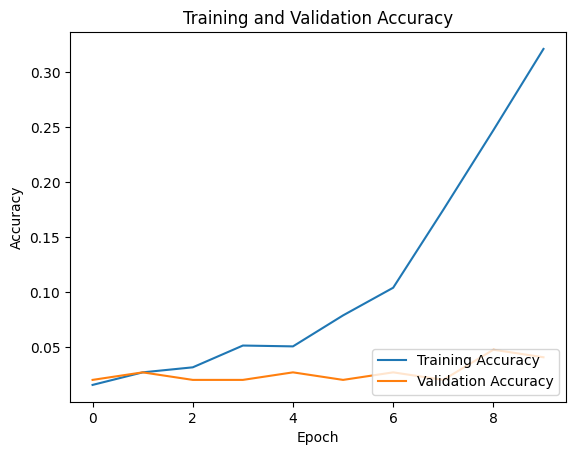

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.0423 - loss: 4.4733
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.043835616438356165
F1 Score: 0.013541942583038476
Precision: 0.009562389865201689
Recall: 0.043835616438356165


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 6000, 256)      │    15,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6000, 256)      │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 44)             │         5,676 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,858,604 (60.50 MB)

 Trainable params: 15,858,604 (60.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=128)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.0400 - loss: 3.7586 - val_accuracy: 0.0548 - val_loss: 3.6742
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.0368 - loss: 3.6854 - val_accuracy: 0.0479 - val_loss: 3.6508
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.0621 - loss: 3.5977 - val_accuracy: 0.0479 - val_loss: 3.7057
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.0754 - loss: 3.4798 - val_accuracy: 0.0342 - val_loss: 3.5037
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.0730 - loss: 3.3314 - val_accuracy: 0.0959 - val_loss: 3.3838
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.0948 - loss: 3.2476 - val_accuracy: 0.1096 - val_loss: 3.3557
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.0888 - loss: 3.1600 - val_accuracy: 0.1233 - val_loss: 3.0742
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.1094 - loss: 2.9880 - val_accuracy: 0.1712 - val_loss:

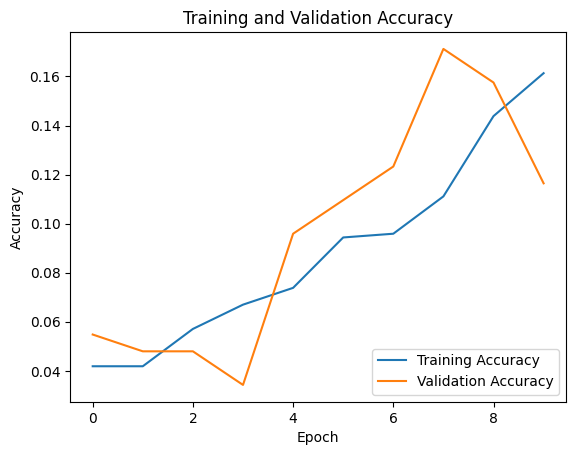

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1446 - loss: 3.0505
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.1589041095890411
F1 Score: 0.10257220831900458
Precision: 0.10805983450688486
Recall: 0.1589041095890411


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(128, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 6000, 256)      │    15,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 6000, 128)      │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 44)             │         2,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,613,548 (59.56 MB)

 Trainable params: 15,613,548 (59.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=128)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 160s 14s/step - accuracy: 0.0284 - loss: 3.7781 - val_accuracy: 0.0274 - val_loss: 3.7507
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 154s 14s/step - accuracy: 0.0477 - loss: 3.7204 - val_accuracy: 0.0342 - val_loss: 3.7168
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 152s 14s/step - accuracy: 0.0452 - loss: 3.6666 - val_accuracy: 0.0274 - val_loss: 3.7296
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 152s 14s/step - accuracy: 0.0481 - loss: 3.5779 - val_accuracy: 0.0274 - val_loss: 3.6687
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 153s 14s/step - accuracy: 0.0687 - loss: 3.4422 - val_accuracy: 0.0274 - val_loss: 3.7605
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 153s 14s/step - accuracy: 0.0622 - loss: 3.5266 - val_accuracy: 0.0411 - val_loss: 3.6373
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 153s 14s/step - accuracy: 0.0969 - loss: 3.3563 - val_accuracy: 0.0274 - val_loss: 3.6319
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 153s 14s/step - accuracy: 0.0962 - loss: 3.2662 - val_accuracy: 0.

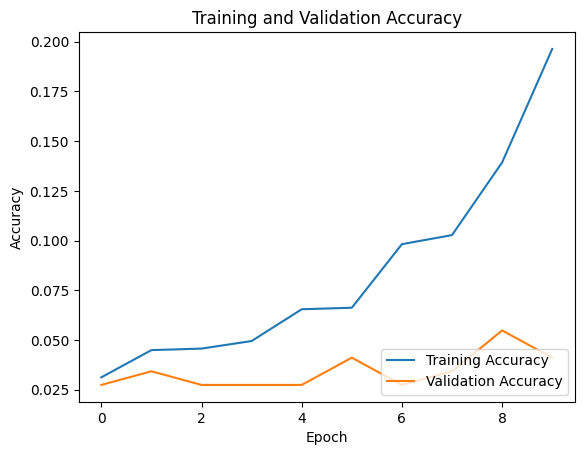

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0279 - loss: 3.7781
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.0410958904109589
F1 Score: 0.024754224322933116
Precision: 0.07222792798460428
Recall: 0.0410958904109589
